# In this notebook are some steps on how to use AltaiPony to extract flares from photometry, estimate flare energies and calculate flare frequency distributions (FFD)

# relevant imports and functions to use:

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt



def get_is_and_not_flare_indices(Altai_flare_fits, smoothed_LC):
    all_flare_inds = []
    for i, r in Altai_flare_fits.iterrows():

        sta, sto = int(r.istart), int(r.istop)+1
            
        flare_mask = np.where((smoothed_LC.time.to_numpy()>=np.min(smoothed_LC.time.to_numpy()[sta:sto]) ) & 
                              (smoothed_LC.time.to_numpy()<=np.max(smoothed_LC.time.to_numpy()[sta:sto]) ) )[0]
        all_flare_inds = np.append(all_flare_inds,flare_mask)
    all_flare_inds = all_flare_inds.astype(int)
    all_non_flare_inds=[]
    #find non-flare points
    for i in range(len(smoothed_LC.time.to_numpy())):
        if smoothed_LC.time.to_numpy()[i] not in smoothed_LC.time.to_numpy()[all_flare_inds]:
            all_non_flare_inds=np.append(all_non_flare_inds, i)
    all_non_flare_inds=all_non_flare_inds.astype(int)
    
    return all_flare_inds, all_non_flare_inds

def altai_flare_fig1(Altai_flare_fits, smoothed_LC,
                     fs, output_filename):
    from collections import OrderedDict
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FormatStrFormatter

    plt.rc("font", size=fs,family='serif')
    # figure 1: pre-processing, flare detection, residuals
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

#     ax2b = fig.add_subplot(324)
#     ax3a = fig.add_subplot(325)
#     ax3b = fig.add_subplot(326)
    ax1.set_ylabel('Normalized Relative Flux',fontsize=fs)
    ax2.set_ylabel('Normalized Detrended Flux',fontsize=fs)
    ax3.set_ylabel('Residuals',fontsize=fs)
    ax3.set_xlabel('Time [BTJD]',fontsize=fs)
#     ax3b.set_xlabel('Time [BTJD]',fontsize=12)
    
#     axs = [ax1a,ax1b,ax2a,ax2b,ax3a,ax3b]
    axs = [ax1,ax2,ax3]
    for ax in axs:
        ax.tick_params(which='both',axis='both',direction='in',top=True,right=True)
        ax.tick_params(which='major',length=6)
    
    # top row: raw flux with fitted trend_line
    ax1.scatter(smoothed_LC.time,
                smoothed_LC.raw_flux,color='black',s=0.25,label='Data')
    ax1.scatter(smoothed_LC.time,
                smoothed_LC.trend,color='cyan',s=0.025**2,label='Trend Line')
    ax1.legend(loc='upper right',fontsize=fs-4)
    #2nd row: detrended flux with flagged flare events
    all_flare_inds, all_non_flare_inds =get_is_and_not_flare_indices(Altai_flare_fits, 
                                                                     smoothed_LC)
    ax2.scatter(smoothed_LC.time,
                smoothed_LC.flux,color='black',s=0.25**2,zorder=100)
    
    ax2.scatter(smoothed_LC.time.to_numpy()[all_flare_inds], 
                smoothed_LC.flux.to_numpy()[all_flare_inds], color='red',
                s=2**2, zorder=-1,label='Flagged Flare')
    #remove duplicate labels in legend of row 2
    handles, labels = ax2.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys(), 
               loc='upper right',fontsize=fs-4)
    
    residuals = smoothed_LC.flux.to_numpy()[all_non_flare_inds]-np.nanmedian(smoothed_LC.flux.to_numpy()[all_non_flare_inds])
    
    ax3.scatter(smoothed_LC.time.to_numpy()[all_non_flare_inds], 
                residuals,
                s=1**2, color='black',zorder=1)
    
    ndigits=2
    if np.nanmedian(np.round(residuals,2))==0:
        ndigits=3
    ax3.yaxis.set_major_formatter(FormatStrFormatter('%.'+str(ndigits)+'f'))
    
    fig.tight_layout(pad=1)
    fig.savefig(output_filename,bbox_inches='tight')#,dpi=100)
    plt.show()    


def altai_flare_fig2(smoothed_LC,Altai_flare_fits,minsep,output_filename): #flare inspection
    from matplotlib.backends.backend_pdf import PdfPages
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import astropy.units as u
    cad = (np.nanmedian(np.diff(smoothed_LC.time)))*u.day
    
    flare_window = cad*minsep
    
    flare_window=flare_window.value
    
    
    all_flare_inds, all_non_flare_inds = get_is_and_not_flare_indices(Altai_flare_fits, smoothed_LC)
    
    with PdfPages(output_filename) as pdf:
        for F in range(len(Altai_flare_fits)):
            flare = Altai_flare_fits.sort_values(by='tstart').iloc[F]
            flare_lc_mask = np.where( (smoothed_LC.time>=flare['tstart'])  & 
                                      (smoothed_LC.time<=flare['tstop'])
                                    )[0]
            fig=plt.figure(figsize=(8,6))
            ax1=fig.add_subplot(211)
            ax2=fig.add_subplot(212)
            mint = flare['tpeak'].item()
            
            ax1.scatter(smoothed_LC.time-mint,smoothed_LC.raw_flux,s=2**2,color='black',zorder=0)
            ax1.scatter(smoothed_LC.time[flare_lc_mask]-mint,smoothed_LC.raw_flux[flare_lc_mask],s=2**2,color='red',zorder=1)
            ax1.scatter(smoothed_LC.time[all_flare_inds]-mint,smoothed_LC.raw_flux[all_flare_inds],s=4**2,color='cyan',zorder=-1)
            
            
            ax1.set_ylim(np.nanmin(smoothed_LC.raw_flux[flare_lc_mask])-3*np.nanstd(smoothed_LC.raw_flux[flare_lc_mask]),
                         np.nanmax(smoothed_LC.raw_flux[flare_lc_mask])+3*np.nanstd(smoothed_LC.raw_flux[flare_lc_mask]))
            
            ax2.scatter(smoothed_LC.time-mint,smoothed_LC.flux,s=2**2,color='black',zorder=0)
            ax2.scatter(smoothed_LC.time[flare_lc_mask]-mint,smoothed_LC.flux[flare_lc_mask],s=2**2,color='red',zorder=1)
            ax2.scatter(smoothed_LC.time[all_flare_inds]-mint,smoothed_LC.flux[all_flare_inds],s=4**2,color='cyan',zorder=-1)
            
            
            # xmin,xmax=-3/24, 3/24
            xmin = flare['tstart'].item()- 10*flare_window-mint
            xmax = flare['tstop'].item() + 10*flare_window-mint
            
            ax1.set_xlim(xmin,xmax)
            ax2.set_xlim(xmin,xmax)            

            ax2.set_ylim(np.nanmin(smoothed_LC.flux[flare_lc_mask])-3*np.nanstd(smoothed_LC.flux[flare_lc_mask]),
                         np.nanmax(smoothed_LC.flux[flare_lc_mask])+3*np.nanstd(smoothed_LC.flux[flare_lc_mask]))
            ypos=0.8
            xpos=0.025
            amp = flare['Fpeak'].item()
            dur = flare['dur'].item()
            tstart=flare['tstart'].item()
            tstop=flare['tstop'].item()
            s=' amplitude: '+str(np.round(amp,3))+'\n dur: '+str( np.round(((dur*u.day).to(u.minute)).value) )+' min'
            ax1.text(xpos,ypos,s,transform = ax1.transAxes)
            
            ax1.axvline(x=tstart-mint,color='grey',linestyle='--',zorder=-10,alpha=0.5)
            ax1.axvline(x=tstop-mint,color='grey',linestyle='--',zorder=-10,alpha=0.5)
            
            ax2.axvline(x=tstart-mint,color='grey',linestyle='--',zorder=-10,alpha=0.5)
            ax2.axvline(x=tstop-mint,color='grey',linestyle='--',zorder=-10,alpha=0.5)
    
            ax1.set_title('Flare # '+str(F)+' Normalized SAP Flux')
            ax2.set_title('Detrended SAP Flux (searched with AltaiPony)')
            ax1.set_ylabel('Normalized Flux')
            ax2.set_ylabel('Normalized Flux')
            ax1.set_xlabel('time since flare peak time: '+str(np.round(mint,4)))
            ax2.set_xlabel('time since flare peak time: '+str(np.round(mint,4)))
            fig.tight_layout(pad=1)
            pdf.savefig(bbox_inches='tight')
            plt.close()
            
def altai_flare_figs(Altai_flare_fits, smoothed_LC, minsep,fs,
                    output_filename1,output_filename2):    
    
    altai_flare_fig1(Altai_flare_fits=Altai_flare_fits,
                     smoothed_LC=smoothed_LC,
                     fs=fs,output_filename=output_filename1)
    
    altai_flare_fig2(smoothed_LC=smoothed_LC, Altai_flare_fits=Altai_flare_fits,
                     minsep=minsep,
                     output_filename=output_filename2)    
    
def get_tpeak_for_altaipony(smoothed_LC,Altai_flare_fits):
    # BEWARE: This is an assumption by me! Not produced by AltaiPony!
    tpeaks=[]
    T= smoothed_LC.time.to_numpy()
    F = smoothed_LC.flux.to_numpy()
    for ii in range(len(Altai_flare_fits)):
        fpeak = Altai_flare_fits.iloc[ii]['ampl_rec']
        tstart = Altai_flare_fits.iloc[ii]['tstart']
        tstop = tstart+Altai_flare_fits.iloc[ii]['dur']/2
        temp=smoothed_LC.loc[(T>tstart) & (T<tstop) &
                             ((F-np.nanmedian(F))<=fpeak)]
        tpeak = temp.iloc[np.argmax(temp.flux)].time
        tpeaks=np.append(tpeaks,tpeak)
    return tpeaks

def get_FWHM_for_altaipony(smoothed_LC,Altai_flare_fits):
    # BEWARE: This is an assumption by me! Not produced by AltaiPony!
    FWHMs=[]
    T= smoothed_LC.time.to_numpy()
    F = smoothed_LC.flux.to_numpy()
    for ii in range(len(Altai_flare_fits)):
        tstart = Altai_flare_fits.iloc[ii]['tstart']
        tstop = Altai_flare_fits.iloc[ii]['tstop']
        flare_window = smoothed_LC.loc[ (T>tstart) & (T<tstop) ]
        time_in_window=flare_window.time.to_numpy()
        flux_in_window=flare_window.time.to_numpy()
        #make initial flare parameter guesses
        cadence=np.nanmedian(np.diff(time_in_window))
        f_half0 = np.where((flux_in_window/np.nanmedian(flux_in_window) >= np.nanmax(flux_in_window/np.nanmedian(flux_in_window))*0.5))
        try:    
            fwhm = np.max(time_in_window[f_half0]) - np.min(time_in_window[f_half0])   
        except ValueError:
            print('Error definining FWHM. min twindow:',np.min(time_in_window),'; max twindow:',np.max(time_in_window))
            print('f_half0:',f_half0)
            print('fmax:',np.nanmax(flux_in_window))
        FWHMs = np.append(FWHMs,fwhm)
    
    return FWHMs

def apply_altai(ID, input_LC,smoothed_input_LC,
               N1,N2,N3,
               fs,output_filename1,output_filename2,
               minsep=None,addtail=False,tailthreshdiff=None):
    import time as clock
    from altaipony.flarelc import FlareLightCurve
    from altaipony.lcio import from_mast
    # reset altaipony backend to default
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    %matplotlib inline

    start=clock.time()
    cad = np.nanmedian(np.diff(smoothed_input_LC.time))
    
    flc = FlareLightCurve(time=input_LC['time'], \
                             flux=input_LC['flux'],\
                             flux_err=input_LC['flux_err'])
    flc.detrended_flux = smoothed_input_LC['flux']
    flc.detrended_flux_err = smoothed_input_LC['flux_err']
    flc.targetid=ID
            
    # turn off warnings since AltaiPony has deprecated pandas applications
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if type(minsep)==type(None):
        # default value, min number of cadences 
        # flare start times should be separated by
        minsep=3 
    import astropy.units as u
    cad = (np.nanmedian(np.diff(smoothed_input_LC.time)))*u.day
    print('Searching for Flares with start times at least',np.round((cad*minsep).to(u.minute).value,3),'minutes apart (using minsep =',minsep,')')
    
    if addtail==False:
        flc_flares = flc.find_flares(N1=N1,N2=N2,N3=N3,minsep=minsep)
    if addtail==True:
        print('WARNING: This is buggy, may result in IndexError...\n'+"I haven't solved it yet :(")
        if type(tailthreshdiff)==type(None):
            tailthreshdiff=1
        flc_flares = flc.find_flares(N1=N1,N2=N2,N3=N3,minsep=minsep,
                                     addtail=addtail,
                                     tailthreshdiff=tailthreshdiff)
            
    flc_flares = flc_flares.flares.sort_values(by="ed_rec", ascending=False)
    
    # edit flare_flares to be in a form I prefer
    Altai_flare_fits = flc_flares
    # Adding/Calculating new column values that doesn't exist:
    #
    #Altai_flare_fits['tpeak']= np.ones_like(Altai_flare_fits['tstart'])*np.nan
    #Altai_flare_fits['FWHM']=np.ones_like(flc_flares['tstart'])*np.nan
    #
    Altai_flare_fits['tpeak']=get_tpeak_for_altaipony(smoothed_input_LC,Altai_flare_fits)
    Altai_flare_fits['Fpeak']=Altai_flare_fits['ampl_rec']
    Altai_flare_fits['Npts']=((Altai_flare_fits['tstop']-Altai_flare_fits['tstart'])/cad).astype(int)
    Altai_flare_fits['equiv_dur']=Altai_flare_fits['ed_rec']
    Altai_flare_fits['FWHM']=get_FWHM_for_altaipony(smoothed_input_LC,Altai_flare_fits)
    Altai_flare_fits['Validation']=len(Altai_flare_fits)*['N']
        
    print('Making Summary Figures')
    altai_flare_figs(Altai_flare_fits=Altai_flare_fits, 
                     smoothed_LC=smoothed_input_LC,minsep=minsep,
                     fs=fs,output_filename1=output_filename1,
                     output_filename2=output_filename2)
    
#     return Altai_flare_fits , flc_flares, flc
    import astropy.units as u
    runtime = clock.time() - start
    if runtime*u.second < 1*u.minute:
        print('total runtime:',np.round(runtime*u.second,3).value,'seconds')
    if runtime*u.second > 1*u.minute:    
        print('total runtime:',(np.round(runtime*u.second,3).to(u.minute)).value,'minutes')
    return Altai_flare_fits , flc


def FFD(LC_summary, TOTEXP=1., Lum=30., fluxerr=0., dur=[], 
        logY=False, est_comp=False,is_altai=True):
    '''
    Given a set of stellar flares, with accompanying durations light curve properties,
    compute the reverse cumulative Flare Frequency Distribution (FFD), and
    approximate uncertainties in both energy and rate (X,Y) dimensions.
    This diagram can be read as measuring the number of flares per day at a
    given energy or larger.
    Not a complicated task, just tedious.
    Y-errors (rate) are computed using Poisson upper-limit approximation from
    Gehrels (1986) "Confidence limits for small numbers of events in astrophysical data", https://doi.org/10.1086/164079
    Eqn 7, assuming S=1.
    X-errors (event energy) are computed following Signal-to-Noise approach commonly
    used for Equivalent Widths in spectroscopy, from
    Vollmann & Eversberg (2006) "Astronomische Nachrichten, Vol.327, Issue 9, p.862", https://dx.doi.org/10.1002/asna.200610645
    Eqn 6.
    Parameters
    ----------
    LC_summary : Pandas dataframe of measured flare parameters (tstart, tpeak, tstop, Fpeak, equiv_dur [days], dur [days])
    TOTEXP : total duration of observations, in days
    Lum : the log luminosity of the star
    fluxerr : the average flux errors of your data (in relative flux units!)
    dur : array of flare durations (in days).
    logY : if True return Y-axis (and error) in log rate (Default: True)
    est_comp : estimate incompleteness using histogram method, scale Y errors?
        (Default: True)
    is_altai: if True, accepts equiv_dur as in seconds already. if False, 
    converts from days to seconds
    Returns
    -------
    ffd_x, ffd_y, ffd_xerr, ffd_yerr
    X coordinate always assumed to be log_10(Energy)
    Y coordinate is log_10(N/Day) by default, but optionally is N/Day
    Upgrade Ideas
    -------------
    - More graceful behavior if only an array of flares and a total duration are
        specified (i.e. just enough to make ffd_x, ffd_y)
    - Better propogation of specific flux errors in the light curve, rather than
        average error used
    - Include detrending errors? (e.g. from a GP)
    - Asymmetric Poisson errors?
    - Better handling of incompleteness?
    '''
    import pandas as pd
    pd.options.mode.chained_assignment = None 
    from astropy.constants import iau2012 as const
    # reverse sort flares in Equiv Dur
    LC_summary=LC_summary.iloc[np.argsort(LC_summary['equiv_dur'].to_numpy())[::-1]]
    ED=LC_summary['equiv_dur'] #if altai, duration is already in seconds
    dur=LC_summary['dur']  
    #
    
    # make ED & dur in seconds from days!
    if is_altai==False:
        ED = ED*24*60*60 # in seconds
    else:
        ED=ED
    
    # REVERSE sort the flares in energy
    #ss = np.argsort(np.array(ED))[::-1]
    #ffd_x = np.log10(ED[ss]) + Lum #ED must be in seconds for units of ffd_x to be in ergs
    
    ffd_x = np.log10(ED) + Lum #ED must be in seconds for units of ffd_x to be in ergs
    
    Num = np.arange(1, len(ffd_x)+1)
    ffd_y = Num / TOTEXP

    # approximate the Poisson Y errors using Gehrels (1986) eqn 7
    Perror = np.sqrt(Num + 0.75) + 1.0
    ffd_yerr = Perror / TOTEXP

    # estimate completeness using the cumulative distribution of the histogram
    if est_comp==True:
        # make very loose guess at how many bins to choose
        nbin = int(np.sqrt(len(ffd_x)))
        if nbin < 10:
            nbin=10 # but use at least 10 bins

        # make histogram of the log(energies)
        try:
            hh, be = np.histogram(ffd_x, bins=nbin, range=[np.nanmin(ffd_x), np.nanmax(ffd_x)])
        except ValueError:
            hh, be = np.histogram(ffd_x, bins=nbin, range=[0, np.nanmax(ffd_x)])
        hh = hh/np.nanmax(hh)
        # make cumulative distribution of the histogram, scale to =1 at the hist peak
        cc = np.cumsum(hh)/np.sum(hh[0:np.argmax(hh)])
        be = (be[1:]+be[0:-1])/2
        # make completeness = 1 for energies above the histogram peak
        cc[np.argmax(hh):] = 1
        # interpolate the cumulative histogram curve back to the original energies
        ycomp = np.interp(ffd_x, be, cc)
        # scale the y-errors by the completeness factor (i.e. inflate small energy errors)
        ffd_yerr = ffd_yerr / ycomp

    if logY:
        # transform FFD Y and Y Error into log10
        ffd_yerr = np.abs(ffd_yerr / np.log(10.) / ffd_y)
        ffd_y = np.log10(ffd_y)
        

    # compute X uncertainties for FFD
    if (len(dur)==len(ffd_x)):
        # assume relative flux error = 1/SN
        S2N = 1/fluxerr
        
        # based on Equivalent Width error
        # Eqn 6, Vollmann & Eversberg (2006) Astronomische Nachrichten, Vol.327, Issue 9, p.862
        ED_err = np.sqrt(2)*(dur* 24*60*60 - ED)/S2N
        ffd_xerr = np.abs((ED_err) / np.log(10.) / ED) # convert to log
    else:
        # not particularly meaningful, but an interesting shape. NOT reccomended
        # print('Warning: Durations not set. Making bad assumptions about the FFD X Error!')
        ffd_xerr = (1/np.sqrt(ffd_x-np.nanmin(ffd_x))/(np.nanmax(ffd_x)-np.nanmin(ffd_x)))
        
        
    #make sure values are finite ONLY (for polyfit reasons)
    
    LC_summary['ffd_x'] =    ffd_x
    LC_summary['ffd_xerr'] = ffd_xerr
    LC_summary['ffd_y'] =    ffd_y
    LC_summary['ffd_yerr'] = ffd_yerr    
    LC_summary=LC_summary.reset_index(drop=True)
    print('FFD len check:',len(ffd_x),len(ffd_xerr),len(ffd_y),len(ffd_yerr))
    #df = pd.DataFrame({'ffd_x':ffd_x,'ffd_xerr':ffd_xerr,'ffd_y':ffd_y,'ffd_yerr':ffd_yerr})
#     with pd.option_context('mode.use_inf_as_null', True):
#         df = df.dropna().reset_index(drop=True)
    #ffd_x,ffd_xerr,ffd_y,ffd_yerr = df['ffd_x'],df['ffd_xerr'],df['ffd_y'],df['ffd_yerr']
    #df=df.reset_index(drop=True)
#     return np.array(ffd_x), np.array(ffd_y), np.array(ffd_xerr), np.array(ffd_yerr), df
    return LC_summary

# Notes on calculating Flare Energy:

## See Eq 1 of https://iopscience.iop.org/article/10.3847/1538-4357/acbd36/pdf

# $E_{\mathrm{flare}} = \int L_{\mathrm{flare}}(t) dt = 2\pi R_{\mathrm{star}}^2 \times \sigma_{\mathrm{SB}}T_{\mathrm{eff}}^4 \times \frac{\int R(\lambda)B(\lambda, T_{\mathrm{eff}} d\lambda)}{\int R(\lambda)B(\lambda, T_{\mathrm{flare}} d\lambda)} \times \int \frac{\Delta F}{F}(t) dt$ 
## where 
## $\frac{R(\lambda)B(\lambda, T_{\mathrm{eff}} d\lambda)}{R(\lambda)B(\lambda, T_{\mathrm{flare}} d\lambda)} = \mathrm{"flux~ratio"}$ and $\int \frac{\Delta F}{F}(t) dt =~\mathrm{"equivalent~duration"}$

# so to simplify

$E_{\mathrm{flare}} = \mathrm{flux~ratio} \times 2\pi R_{\mathrm{star}}^2 \times \sigma_{\mathrm{SB}}T_{\mathrm{eff}}^4 \times \mathrm{equivalent~duration}$ 

In [2]:
def flare_factor(teff, radius, wav, resp,  tflare=float(1e4)):
    # stolen/borrowed from 
    # https://github.com/ekaterinailin/tic277/blob/893b95d63b9642875dd9188951271772aee22145/notebooks/_05_tess_ffds.py#L31
    """Calculate the flare energy factor in ergs.

    Parameters
    ----------
    teff : float
        Stellar effective temperature in Kelvin.
    radius : float
        Stellar radius in solar radii.
    wav : array
        Array of wavelengths in nanometers.
    resp : array
        Array of bandpass responses.
     tflare : float
        Flare temperature in Kelvin. Default 10,000 K.
    
    Returns
    -------
    factor : float
        Flare energy factor in ergs/s.
    """
    from astropy.modeling import models
    from astropy import units as u
    from astropy.constants import sigma_sb

    # blackbody
    bb = models.BlackBody(temperature=teff * u.K)

    # blackbody flux in TESS band
    bbwavs = bb(wav * u.nm)  * resp

    fluxstar = np.trapz(bbwavs.value, wav)

    # blackbody
    bb = models.BlackBody(temperature=tflare * u.K)

    # blackbody flux in TESS band
    bbwavf = bb(wav * u.nm)  * resp

    fluxflare = np.trapz(bbwavf.value, wav)

    ratio = fluxstar / fluxflare

    #print("TESS", ratio)

    factor = ratio * np.pi * (radius * u.R_sun) ** 2 * sigma_sb * (tflare * u.K)**4
    factor = factor.to("erg/s")
    print(factor)
    return factor

kepler_bandpass = np.transpose(np.loadtxt('https://nexsci.caltech.edu/workshop/2012/keplergo/kepler_response_hires1.txt', skiprows=6, comments='#',encoding='utf-16'))
kepler_bandpass = pd.DataFrame({'Wavelength (nm)':kepler_bandpass[0], 'lambda Transmission':kepler_bandpass[1]})
tess_bandpass = pd.read_csv('https://heasarc.gsfc.nasa.gov/docs/tess/data/tess-response-function-v2.0.csv',skiprows=5)
tess_bandpass=tess_bandpass.rename(columns={'# Wavelength (nm)':'Wavelength (nm)',' lambda Transmission':'lambda Transmission' })


tess_bandpass['Wavelength (Angstrom)'] = tess_bandpass['Wavelength (nm)']*10
kepler_bandpass['Wavelength (Angstrom)'] = kepler_bandpass['Wavelength (nm)']*10



# example: YZ CMi

# grab 2min SPOC TESS light curves (this might take a few minutes...)

In [3]:
import lightkurve as lk
from lightkurve import search_targetpixelfile

starname='TIC 266744225'
ID=int(starname[4:])

search_result = lk.search_lightcurve('TIC '+str(ID))
search_result=search_result[search_result.author=='SPOC']
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 07,2019,SPOC,120,266744225,0.0
1,TESS Sector 34,2021,SPOC,20,266744225,0.0
2,TESS Sector 34,2021,SPOC,120,266744225,0.0


In [4]:
import os,sys
SPOCS7 = search_result[0].download(quality_bitmask='hardest',download_dir=os.getcwd()+'/')
SPOCS34_20 = search_result[1].download(quality_bitmask='hardest',download_dir=os.getcwd()+'/')
SPOCS34 = search_result[2].download(quality_bitmask='hardest',download_dir=os.getcwd()+'/')

# useful functions for extracting your own light curves from TPFs/FFIs.
### I find that they're pretty comparable to SPOC/TESS-SPOC SAP FLUX light curves, being mindful that systematics aren't being corrected for at least.


In [5]:
# useful functions for extracting your own light curves from TPFs/FFIs.
# I find that they're pretty comparable to SPOC/TESS-SPOC light curves

def query_region_for_nearby_stars(ID,radial_cone_in_arcsecs):
    #stuff for getting FFI data from MAST
    from astroquery.mast import Catalogs
    import numpy as np
    import time as clock
    import requests

    starName="TIC "+str(ID)
    radial_cone = radial_cone_in_arcsecs/ 3600.0 # angular radius in degrees
    try:
        catalogData = Catalogs.query_object(starName, radius = radial_cone, catalog = "TIC")
    except requests.exceptions.ConnectionError as E:
        clock.sleep(5) #pause 5 seconds then try again
        catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
    #    
    return catalogData

def convert_TessMag_to_Flux(Tmag):
    f = 10**(-(Tmag/2.5))
    return f

def calc_flux_contamination(ID,radial_cone_in_arcseconds=63):

    catalogData = query_region_for_nearby_stars(ID,radial_cone_in_arcseconds)

    Tmag_target_star = catalogData[0]['Tmag']
    Flux_target_star = convert_TessMag_to_Flux(Tmag_target_star)
    Flux_all = []
    for t in range(len(catalogData)):
        Flux_all = np.append(Flux_all, convert_TessMag_to_Flux(catalogData[t]['Tmag']))
    Flux_total = np.sum(Flux_all)

    flux_contamination_ratio = Flux_target_star / Flux_total #this is light FROM the target star
    flux_contamination_ratio = 1 - Flux_target_star / Flux_total #this is light NOT FROM the target star (will produce ratio=0 for 1 - 10^(-Tmag,target/2.5) / 10^(-Tmag,target/2.5)

    return flux_contamination_ratio

def Extract_LC(lk_object,threshold,bkg_threshold,TPForFFI):
    import pandas as pd
    if TPForFFI=='TPF':
        target_mask = lk_object.hdu[2].data & 2 > 0 #SPOC optimal aperture
    else:    
        target_mask = lk_object.create_threshold_mask(threshold=threshold, reference_pixel='center')
    
    n_target_pixels = target_mask.sum()
    target_lc = lk_object.to_lightcurve(aperture_mask=target_mask)
    background_mask = ~lk_object.create_threshold_mask(threshold=bkg_threshold, reference_pixel=None)
    n_background_pixels = background_mask.sum()

    
    background_lc_per_pixel = lk_object.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    background_estimate_lc = background_lc_per_pixel * n_target_pixels
    raw_bkg=background_estimate_lc.remove_nans()
    norm_bkg=background_estimate_lc.normalize()
    cnew=target_lc - background_estimate_lc.flux
    cnew=cnew.remove_nans()#.remove_outliers() #<---- this truncates transits!!!
    
    raw_lc=target_lc#cnew
    corrected_lc = cnew.normalize()
    
    quality_mask = np.where(corrected_lc.quality==0)[0]
    
    corrected_lc = corrected_lc[quality_mask]
    norm_bkg = norm_bkg[quality_mask]
    raw_lc = raw_lc[quality_mask]
    raw_bkg = raw_bkg[quality_mask]
    
    
    #b/c new lightkurve is weird and now requires .value for arrays, use pandas
    
    
    #deblend all light curves within 2 TESS pixels
    f_contam_ratio = calc_flux_contamination(ID,radial_cone_in_arcseconds=21*2)
    
    deblended_corrected_lc_flux = corrected_lc.flux.value - f_contam_ratio
    deblended_corrected_lc_flux = deblended_corrected_lc_flux / np.nanmedian(deblended_corrected_lc_flux)
    
    deblended_raw_lc_flux = raw_lc.flux.value - f_contam_ratio
    deblended_raw_lc_flux = deblended_raw_lc_flux #/ np.nanmedian(deblended_raw_lc_flux)
    
    corrected_lc = pd.DataFrame({'time':corrected_lc.time.value,'flux':deblended_corrected_lc_flux,\
                                'flux_err':corrected_lc.flux_err.value})
    norm_bkg = pd.DataFrame({'time':norm_bkg.time.value,'flux':norm_bkg.flux.value,\
                                'flux_err':norm_bkg.flux_err.value})
    raw_lc = pd.DataFrame({'time':raw_lc.time.value,'flux':deblended_raw_lc_flux,\
                                'flux_err':raw_lc.flux_err.value})
    raw_bkg = pd.DataFrame({'time':raw_bkg.time.value,'flux':raw_bkg.flux.value,\
                                'flux_err':raw_bkg.flux_err.value})
    
    #for PLD detrending later
    
#     print(corrected_lc.time.value)
#     print(deblended_corrected_lc_flux)
#     print(corrected_lc.flux_err.value)
#     print(deblended_raw_lc_flux)
#     print(raw_bkg.flux.value)
    
    master_lc = pd.DataFrame({'Time':np.array(corrected_lc['time']),\
                              'SAP Flux':deblended_corrected_lc_flux,\
                              'SAP Error':np.array(corrected_lc['flux_err']),\
                              'RAW SAP Flux':deblended_raw_lc_flux,\
                              'Background Flux':np.array(raw_bkg['flux'])})
    
    
    return corrected_lc, norm_bkg, raw_lc, raw_bkg, master_lc

# For this example, we'll use SPOC light curves but commented out code below would be for custom extraction

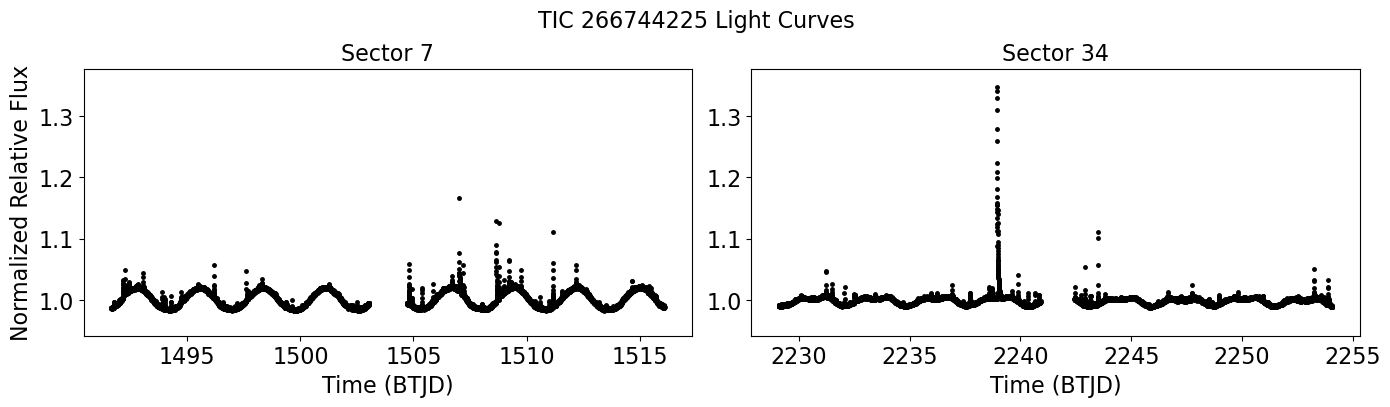

In [6]:
# S7_TPF_LC, S7_TPF_BKG, S7_TPF_RAWLC, S7_TPF_RAWBKG, S7_TPF_master  = Extract_LC(S7tpf, threshold=3,bkg_threshold=1/1000,TPForFFI='TPF')
# S34_TPF_LC,S34_TPF_BKG,S34_TPF_RAWLC,S34_TPF_RAWBKG,S34_TPF_master = Extract_LC(S34tpf,threshold=3,bkg_threshold=1/1000,TPForFFI='TPF')

# Let's see what the photometry looks like:
SPOCS7_pd = pd.DataFrame({'time':SPOCS7.time.value,
                          'flux':SPOCS7.flux.value/np.nanmedian(SPOCS7.flux.value),
                          'flux_err':SPOCS7.flux_err.value/np.nanmedian(SPOCS7.flux.value)})

SPOCS34_pd = pd.DataFrame({'time':SPOCS34.time.value,
                           'flux':SPOCS34.flux.value/np.nanmedian(SPOCS34.flux.value),
                           'flux_err':SPOCS34.flux_err.value/np.nanmedian(SPOCS34.flux.value)})

SPOCS34_20_pd = pd.DataFrame({'time':SPOCS34_20.time.value,
                              'flux':SPOCS34_20.flux.value/np.nanmedian(SPOCS34_20.flux.value),
                              'flux_err':SPOCS34_20.flux_err.value/np.nanmedian(SPOCS34_20.flux.value)})

fs=16
fig=plt.figure(figsize=(14,7))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)


def plot_LC(LC,ax,label):
    try:
        ax.plot(LC.time,LC.flux,'k.',markersize=5)
        ax.set_ylim(np.nanmin(LC.flux)-3*np.nanstd(LC.flux),np.nanmax(LC.flux)+3*np.nanstd(LC.flux))
    except AttributeError: #for PLD detrended LCs, later
        ax.plot(LC['Time'],LC['PLD Flux'],'k.',markersize=5)
        ax.set_ylim(np.nanmin(LC['PLD Flux'])-3*np.nanstd(LC['PLD Flux']),np.nanmax(LC['PLD Flux'])+3*np.nanstd(LC['PLD Flux']))        
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.set_xlabel('Time (BTJD)',fontsize=fs)
    ax.set_rasterized(True)
    ax.set_title(label,fontsize=fs)
    
ax1.set_ylabel('Normalized Relative Flux',fontsize=fs)    

# plot_LC(S7_TPF_LC,ax1,label='Sector 7')
# plot_LC(S34_TPF_LC,ax2,label='Sector 34')

plot_LC(SPOCS7_pd,ax1,label='Sector 7')
plot_LC(SPOCS34_pd,ax2,label='Sector 34')

ymin,ymax = np.min([ax1.get_ylim(),ax2.get_ylim()]),np.max([ax1.get_ylim(),ax2.get_ylim()])
ax1.set_ylim(ymin,ymax)
ax2.set_ylim(ymin,ymax)

fig.suptitle(starname+' Light Curves',x=0.5,y=0.975,fontsize=fs)
fig.tight_layout(pad=1)
plt.show()


# Smooth LC for easier detection (use your favorite algorithm!)



In [7]:
# I'll use lightkurve's savitsky-golay filter (which is pretty commonly used)

def detrend_wotan(window,lc,filter_type,LCorLK,polyorder=None):
    window_size=window
    from wotan import flatten
    import pandas as pd

    if LCorLK=='LC':
        T=np.array(lc.time)
        F=np.array(lc.flux)
        E=np.array(lc.flux_err)
    if LCorLK=='LK':
        T=np.array(lc.time.value)
        F=np.array(lc.flux.value)
        E=np.array(lc.flux_err.value)             
        
    #sort by time (just in case)
    tsort = np.argsort(T)
    T = T[tsort]
    F = F[tsort]
    E = E[tsort]    
    orig_F=F
    orig_E=E
        
    if (filter_type=='medfilt'):
        # this filter type needs a window size in number of data points
        # instead of a window size in unit of time
        # Below converts input window size to number of data points:
        cadence = np.nanmedian(np.diff(T))
        def round_up_to_odd(f):
            return int(np.ceil(f) // 2 * 2 + 1)
        Npts = round_up_to_odd(int((window)/cadence))        
        flatten_lc, trend_lc = flatten(T,F, window_length=Npts,
                               return_trend=True, break_tolerance=0,
                               method=filter_type,robust=True)#,edge_cutoff=0.5)
    if (filter_type=='biweight'):
        flatten_lc, trend_lc = flatten(T,F, window_length=window_size, 
                                       return_trend=True, break_tolerance=0,
                                       method=filter_type,robust=True)#,edge_cutoff=0.5)
#     print('len check')
#     print('before: ',len(T),len(F),len(E))
#     print('after:',len(flatten_lc),len(trend_lc))
    #check for NaNs
    nanmask = np.where(np.isfinite(flatten_lc)==True)[0]
    T = T[nanmask]
    F = flatten_lc[nanmask]
    E =E[nanmask]
    import lightkurve as lk
    newlc = lk.LightCurve(time=T,flux=F,flux_err=E)#.remove_outliers(sigma_lower=np.inf,sigma_upper=3)
    newlc = pd.DataFrame({'time':newlc.time.value,'flux':newlc.flux.value,
                          'flux_err':newlc.flux_err.value,
                          'trend':trend_lc,
                          'raw_flux':orig_F,
                          'raw_flux_err':orig_E})
       
    if (filter_type=='savgol') or (filter_type=='savitsky-golay'):
        import lightkurve as lk
        if type(polyorder)==type(None):
            polyorder=3

        cadence = np.nanmedian(np.diff(input_LC.time))
        def round_up_to_odd(f): #must be an odd number!
            return int(np.ceil(f) // 2 * 2 + 1)
        Npts = round_up_to_odd(int((window_size)/cadence)) 
        print('Smoothing Window in days:',window_size,'; in data points:',Npts)

        newlc,trend_lc = lk.LightCurve(time=input_LC.time,
                                              flux=input_LC.flux,
                                              flux_err=input_LC.flux_err).flatten(window_length=Npts,
                                                                                  polyorder=polyorder, 
                                                                                  return_trend=True)
        #instead of retuning lk.LightCurve, return pandas dataframe instead
        import pandas as pd
        newlc = pd.DataFrame({'time':newlc.time.value,'flux':newlc.flux.value,
                          'flux_err':newlc.flux_err.value,
                          'trend':trend_lc.flux.value/np.nanmedian(orig_F),
                          'raw_flux':orig_F,
                          'raw_flux_err':orig_E})

        flatten_lc = newlc.flux.value
    return newlc,trend_lc,flatten_lc



In [8]:
# Let's use a 10 hour smoothing window
smoothing_window_in_days=10/24

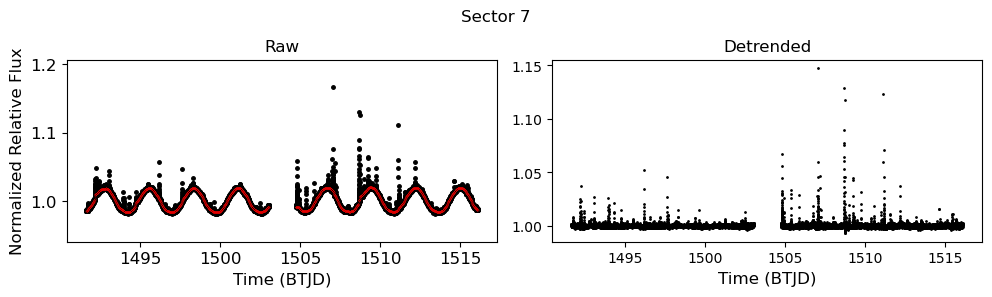

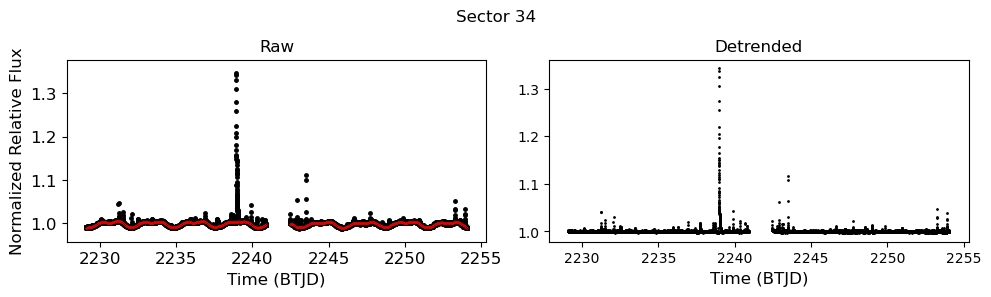

In [9]:
S7_smoothed_LC,trend_lc7,flatten_lc7 = detrend_wotan(window=smoothing_window_in_days,
                                                     lc=SPOCS7_pd,filter_type='medfilt',
                                                     LCorLK='LC')
S34_smoothed_LC,trend_lc34,flatten_lc34 = detrend_wotan(window=smoothing_window_in_days,
                                                     lc=SPOCS34_pd,filter_type='medfilt',
                                                     LCorLK='LC')

#note: biweight is pretty good too! Shown to be great for exoplanets!
# https://arxiv.org/abs/1906.00966

fs=12
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(221)
ax2=fig.add_subplot(222)

# ax.scatter(S7_TPF_LC.time,S7_TPF_LC.flux,color='black',s=1)
# ax.plot(S7_trend_lc.time,S7_trend_lc.flux,color='red',lw=2)

plot_LC(SPOCS7_pd,ax,label='Raw')
ax.scatter(S7_smoothed_LC.time,S7_smoothed_LC.trend,color='red',s=0.025**2,zorder=100)


ax2.scatter(S7_smoothed_LC.time,S7_smoothed_LC.flux,color='black',s=1)
fig.suptitle('Sector 7',x=0.5,y=0.975)
ax.set_ylabel('Normalized Relative Flux',fontsize=fs)    
ax.set_xlabel('Time (BTJD)',fontsize=fs)
ax2.set_xlabel('Time (BTJD)',fontsize=fs)
ax2.set_title('Detrended')
fig.tight_layout(pad=1)
plt.show()


fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(221)
ax2=fig.add_subplot(222)
# ax.scatter(S34_TPF_LC.time,S34_TPF_LC.flux,color='black',s=1)
# ax.plot(S34_trend_lc.time,S34_trend_lc.flux,color='red',lw=2)

plot_LC(SPOCS34_pd,ax,label='Raw')
ax.scatter(S34_smoothed_LC.time,S34_smoothed_LC.trend,color='red',s=0.025**2,zorder=100)

ax2.scatter(S34_smoothed_LC.time,S34_smoothed_LC.flux,color='black',s=1)
fig.suptitle('Sector 34',x=0.5,y=0.975)
ax.set_ylabel('Normalized Relative Flux',fontsize=fs)    
ax.set_xlabel('Time (BTJD)',fontsize=fs)
ax2.set_xlabel('Time (BTJD)',fontsize=fs)
ax2.set_title('Detrended')
fig.tight_layout(pad=1)
plt.show()

# Save results before using AltaiPony

In [10]:
# save data
# S7_TPF_LC.to_csv('TESS_YZ_CMi_Sector_7_light_curve.csv',index=False)
# S34_TPF_LC.to_csv('TESS_YZ_CMi_Sector_34_light_curve.csv',index=False)
# input_LC = pd.concat([S7_TPF_LC,S34_TPF_LC)]).reset_index(drop=True)


#use SPOC instead
SPOCS7_pd = pd.DataFrame({'time':SPOCS7.time.value,'flux':SPOCS7.flux.value,'flux_err':SPOCS7.flux_err.value})
SPOCS34_pd = pd.DataFrame({'time':SPOCS34.time.value,'flux':SPOCS34.flux.value,'flux_err':SPOCS34.flux_err.value})
SPOCS34_20_pd = pd.DataFrame({'time':SPOCS34_20.time.value,'flux':SPOCS34_20.flux.value,'flux_err':SPOCS34_20.flux_err.value})

SPOCS7_pd.to_csv('TESS_YZ_CMi_Sector_7_light_curve.csv',index=False)
SPOCS34_pd.to_csv('TESS_YZ_CMi_Sector_34_light_curve.csv',index=False)
SPOCS34_20_pd.to_csv('TESS_YZ_CMi_Sector_34_light_curve_20sec.csv',index=False)

input_LC = pd.concat([SPOCS7_pd,SPOCS34_pd]).reset_index(drop=True)
smoothed_input_LC = pd.concat([S7_smoothed_LC,S34_smoothed_LC]).reset_index(drop=True)


input_LC.to_csv('TESS_YZ_CMi_Sector_7_and_34_light_curves.csv',index=False)
smoothed_input_LC.to_csv('TESS_YZ_CMi_Sector_7_and_34_smoothed_light_curves.csv',index=False)
S7_smoothed_LC.to_csv('TESS_YZ_CMi_Sector_7_smoothed_light_curve.csv',index=False)
S34_smoothed_LC.to_csv('TESS_YZ_CMi_Sector_34_smoothed_light_curve.csv',index=False)



In [11]:
# from altaipony.flarelc import FlareLightCurve
# from altaipony.lcio import from_mast


# Next, use AltaiPony to detect flares. First let's checking what a meaningful minimum flare start time separation should be

# start with Sector 7

In [12]:
# calc min flare separation in (time)
import astropy.units as u
cad = (np.nanmedian(np.diff(S7_smoothed_LC.time)))*u.day
minsep = np.round(5)
print('Searching for Flares with start times at least',np.round((cad*minsep).to(u.minute).value,3),'minutes apart (using minsep =',minsep,')')

Searching for Flares with start times at least 10.0 minutes apart (using minsep = 5 )


# next choose what AltaiPony settings we should use for N1, N2 and N3

In [13]:
((np.nanmedian(np.diff(input_LC['time']))*u.day).to(u.minute) > 1*u.minute) & ((np.nanmedian(np.diff(input_LC['time']))*u.day).to(u.minute) <= 30*u.minute) 

True

In [14]:
N1=2
N2=1

if (np.nanmedian(np.diff(input_LC['time']))*u.day).to(u.minute) < 1*u.minute:
    N3=5    
if ((np.nanmedian(np.diff(input_LC['time']))*u.day).to(u.minute) > 1*u.minute) & ((np.nanmedian(np.diff(input_LC['time']))*u.day).to(u.minute) <= 30*u.minute):
    N3=3
print(' N1, N2, N3: \n',N1,'',N2,'',N3) 


 N1, N2, N3: 
 2  1  3


Searching for Flares with start times at least 10.0 minutes apart (using minsep = 5 )


/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
Found 88 candidate(s) in the (0,8152) gap.
Found 95 candidate(s) in the (8152,16299) gap.


Making Summary Figures


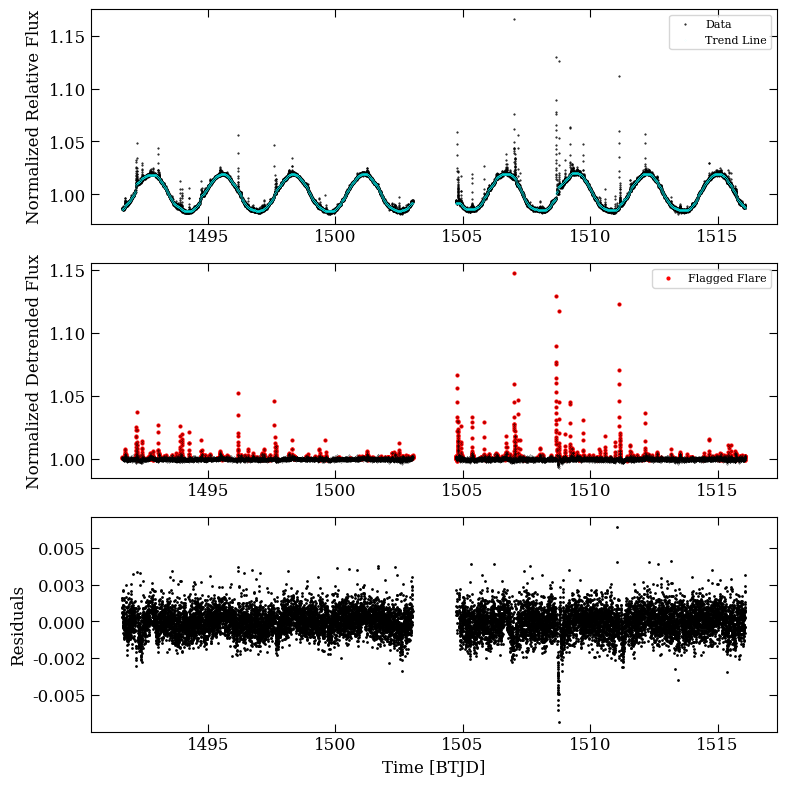

/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


total runtime: 21.878 seconds


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,tpeak,Fpeak,Npts,equiv_dur,FWHM,Validation
119,10974,11003,NaN,NaN,1508.655244,1508.695522,107.189883,0.215367,0.129356,0.040277,16299.0,1508.656633,0.129356,28,107.189883,0.037500,N
109,9803,9841,NaN,NaN,1507.014980,1507.067757,83.261362,0.213513,0.147734,0.052777,16299.0,1507.023313,0.147734,37,83.261362,0.050000,N
89,8194,8249,NaN,NaN,1504.777486,1504.853875,82.032234,0.288113,0.067121,0.076389,16299.0,1504.789986,0.067121,55,82.032234,0.073611,N
138,12754,12787,NaN,NaN,1511.142712,1511.188544,65.612843,0.180451,0.123057,0.045833,16299.0,1511.144101,0.123057,32,65.612843,0.043055,N
120,11051,11067,NaN,NaN,1508.762188,1508.784410,33.232135,0.119557,0.117875,0.022222,16299.0,1508.763576,0.117875,15,33.232135,0.019444,N
123,11377,11396,NaN,NaN,1509.216349,1509.242738,24.545972,0.155276,0.045055,0.026389,16299.0,1509.217738,0.045055,18,24.545972,0.023611,N
37,3232,3245,NaN,NaN,1496.177483,1496.195539,22.124684,0.143370,0.052453,0.018056,16299.0,1496.178872,0.052453,13,22.124684,0.015278,N
92,8616,8642,NaN,NaN,1505.363597,1505.399708,21.774471,0.175440,0.033597,0.036111,16299.0,1505.364986,0.033597,26,21.774471,0.033333,N
148,13482,13515,NaN,NaN,1512.159361,1512.205193,19.627129,0.176509,0.037068,0.045832,16299.0,1512.160750,0.037068,32,19.627129,0.043055,N
5,415,438,NaN,NaN,1492.219089,1492.252423,18.609059,0.168937,0.037132,0.033334,16299.0,1492.231590,0.037132,24,18.609059,0.029167,N


In [15]:
flc7, flc_lc7 = apply_altai(ID=ID, input_LC=SPOCS7_pd,
                            smoothed_input_LC=S7_smoothed_LC,
                            N1=N1,N2=N2,N3=N3,fs=12,minsep=minsep,
                            output_filename1='TESS_YZ_CMi_Sector_7_AltaiPony_Flare_Summary.png',
                            output_filename2='TESS_YZ_CMi_Sector_7_AltaiPony_Flare_inspection.pdf')

flc7.to_csv('TESS_YZ_CMi_Sector_7_AltaiPony_Flare_Fits.csv')
flc7.head(10)

Searching for Flares with start times at least 10.0 minutes apart (using minsep = 5 )


Found 79 candidate(s) in the (0,8480) gap.
Found 83 candidate(s) in the (8480,16794) gap.


Making Summary Figures


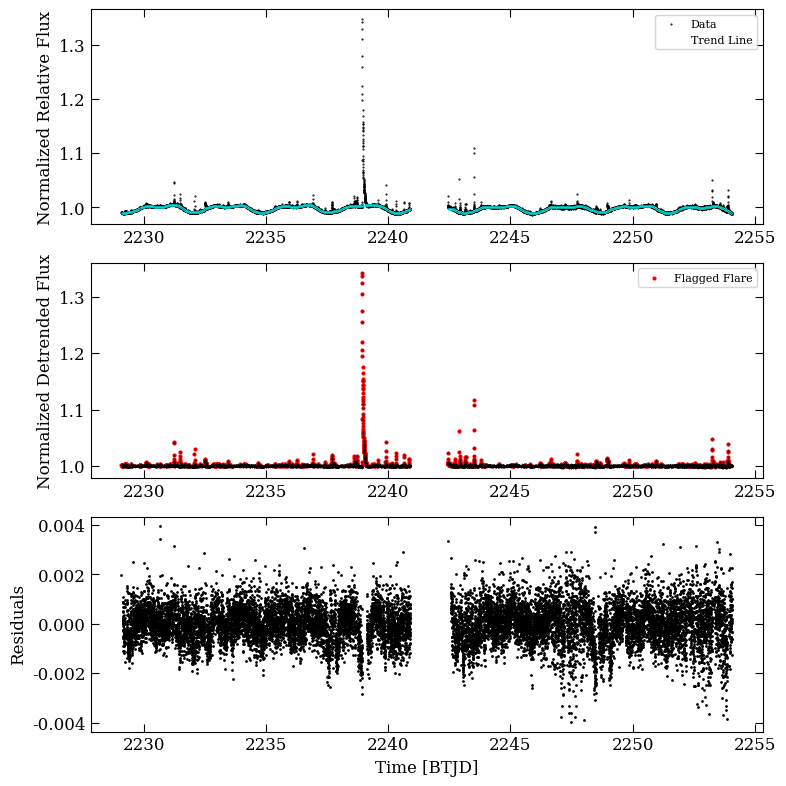

total runtime: 19.824 seconds


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,tpeak,Fpeak,Npts,equiv_dur,FWHM,Validation
68,7061,7193,NaN,NaN,2238.935489,2239.120209,853.544046,0.413981,0.343091,0.184720,16794.0,2238.943823,0.343091,133,853.544046,0.181942,N
89,9234,9255,NaN,NaN,2243.492357,2243.521523,49.643260,0.136367,0.117184,0.029166,16794.0,2243.493746,0.117184,21,49.643260,0.026388,N
79,8481,8566,NaN,NaN,2242.442371,2242.560425,33.694264,0.426183,0.023100,0.118054,16794.0,2242.450704,0.023100,85,33.694264,0.115276,N
154,16227,16279,NaN,NaN,2253.262931,2253.335150,31.146233,0.208103,0.048118,0.072219,16794.0,2253.264320,0.048118,51,31.146233,0.069442,N
160,16652,16691,NaN,NaN,2253.871240,2253.926793,30.618794,0.227360,0.038168,0.055553,16794.0,2253.874017,0.038168,39,30.618794,0.052776,N
22,2447,2484,NaN,NaN,2232.498029,2232.550806,29.402671,0.316835,0.011800,0.052778,16794.0,2232.509140,0.011800,38,29.402671,0.048611,N
123,13144,13181,NaN,NaN,2248.961684,2249.014461,28.443476,0.310906,0.014119,0.052776,16794.0,2248.968629,0.014119,37,28.443476,0.049999,N
121,12821,12879,NaN,NaN,2248.508919,2248.590861,25.097846,0.383834,0.009630,0.081942,16794.0,2248.510308,0.009630,58,25.097846,0.079165,N
61,6175,6201,NaN,NaN,2237.700783,2237.736893,23.168673,0.231972,0.018789,0.036111,16794.0,2237.709116,0.018789,26,23.168673,0.033333,N
84,8821,8841,NaN,NaN,2242.915976,2242.943753,22.665314,0.146444,0.062424,0.027777,16794.0,2242.917365,0.062424,20,22.665314,0.025000,N


In [16]:
flc34, flc_lc34 = apply_altai(ID=ID, input_LC=SPOCS34_pd,
                            smoothed_input_LC=S34_smoothed_LC,
                            N1=N1,N2=N2,N3=N3,fs=12,minsep=minsep,
                            output_filename1='TESS_YZ_CMi_Sector_34_AltaiPony_Flare_Summary.png',
                            output_filename2='TESS_YZ_CMi_Sector_34_AltaiPony_Flare_inspection.pdf')

flc34.to_csv('TESS_YZ_CMi_Sector_34_AltaiPony_Flare_Fits.csv')
flc34.head(10)

# let's also combine FFDs for later comparison

In [17]:
flc7_and_34 = pd.concat([flc7,flc34]).reset_index(drop=True).sort_values(by='ed_rec')
flc7_and_34.head(10)

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,tpeak,Fpeak,Npts,equiv_dur,FWHM,Validation
182,6399,6402,NaN,NaN,1500.595561,1500.599728,0.367932,0.096182,0.001037,0.004167,16299.0,1500.596950,0.001037,3,0.367932,0.001389,N
181,5659,5662,NaN,NaN,1499.567783,1499.571949,0.374810,0.095199,0.001083,0.004167,16299.0,1499.569171,0.001083,3,0.374810,0.001389,N
180,7194,7197,NaN,NaN,1501.710836,1501.715003,0.375133,0.095965,0.001091,0.004167,16299.0,1501.712225,0.001091,2,0.375133,0.001389,N
179,4073,4076,NaN,NaN,1497.349716,1497.353883,0.375626,0.095279,0.001131,0.004167,16299.0,1497.351105,0.001131,3,0.375626,0.001389,N
178,13335,13338,NaN,NaN,1511.953809,1511.957976,0.380751,0.096115,0.001123,0.004167,16299.0,1511.955198,0.001123,2,0.380751,0.001389,N
177,2647,2650,NaN,NaN,1495.364974,1495.369141,0.383092,0.096378,0.001147,0.004167,16299.0,1495.366363,0.001147,3,0.383092,0.001389,N
176,1420,1423,NaN,NaN,1493.639949,1493.644116,0.386626,0.095164,0.001156,0.004167,16299.0,1493.641338,0.001156,3,0.386626,0.001389,N
344,11179,11182,NaN,NaN,2246.202030,2246.206196,0.388124,0.096348,0.001108,0.004167,16794.0,2246.203419,0.001108,2,0.388124,0.001389,N
175,5174,5177,NaN,NaN,1498.891392,1498.895558,0.389073,0.096113,0.001124,0.004167,16299.0,1498.892781,0.001124,3,0.389073,0.001389,N
174,1111,1114,NaN,NaN,1493.209386,1493.213553,0.395005,0.096184,0.001159,0.004167,16299.0,1493.210775,0.001159,3,0.395005,0.001389,N


# "apply_altai" also produces a PDF file which contains a multi-page vetting report for each detected flare. Before vetting, each flare is given a "N" (Not a flare) flag.

# I've gone ahead and visually inspected whichs ones appear flare-like and set their 'Validation' flags to 'Y' (is a flare) below:

In [18]:
s7_is_flares = [1, 2, 3,4,5,6,8, 9, 11,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,46,47,48,49,50,52,52,53,55,56,57,58,59,61,66,68,69,70,71,74,75,76,77,78,79,80,81,82,83,84,89,90,91,92,93,95,96,97,98,99,100,101,102,106,107,108,109,110,111,112,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,143,144,147,148,149,152,153,155,156,157,158,159,162,163,164,165,166,167,168,169,171,172,173,174,175,176,177,178,179,180,181]
s34_is_flares = [1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,81,82,83,84,85,86,88,89,90,91,92,94,95,97,98,99,101,102,103,104,105,106,107,108,110,111,112,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,145,146,149,150,151,152,153,154,158,159,160,161]
s34_is_flares_20s = [2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,70,71,72,73,74,75,76,77,78,80,81,82,83,84,85,86,87,88,89,90,91,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,141,142,143,145,147,148,150,151,152,153,154,155,156,157,158,159]

flc7.loc[s7_is_flares, 'Validation']='Y'
flc34.loc[s34_is_flares, 'Validation']='Y'



flc7.to_csv('TESS_YZ_CMi_Sector_7_AltaiPony_Flare_Fits.csv')
flc34.to_csv('TESS_YZ_CMi_Sector_34_AltaiPony_Flare_Fits.csv')


# estimate flare energy based on Kepler, TESS passbands and a blackbody of a given temperature 

In [19]:
# from Baroach et al. 2020 https://www.aanda.org/articles/aa/pdf/2020/09/aa38213-20.pdf
R_star = 0.369
R_star_unc= np.mean([0.027,0.055])
M_star = R_star #ASSUMPTION, NOT LISTED
M_star_unc = R_star_unc #ASSUMPTION, NOT LISTED
Teff = 3100
Teff_unc = np.mean([50])
distance = 5.9874 #pc
logg =  5


# ex usage: 
print('TESS flare energy for 10,000 K flare')
tess_flare_factor = flare_factor(teff=Teff, radius=R_star, wav = tess_bandpass["Wavelength (nm)"].values, resp=tess_bandpass["lambda Transmission"].values)    
print(' ')
print('Kepler flare energy for 10,000 K flare')
kepler_flare_factor = flare_factor(teff=Teff, radius=R_star, wav = kepler_bandpass["Wavelength (nm)"].values, resp=kepler_bandpass["lambda Transmission"].values)    
print(' ')
# nflares["ed_rec"] = nflares.ed_rec * factor.value
# nflares["ed_rec_err"] = nflares.ed_rec_err * factor.value


TESS flare energy for 10,000 K flare
1.7013422141179704e+31 erg / s
 
Kepler flare energy for 10,000 K flare
8.065932111567394e+30 erg / s
 


In [20]:
#re read in saved LCs
TESS_LCDF_smoothed_7= pd.read_csv('TESS_YZ_CMi_Sector_7_smoothed_light_curve.csv')
TESS_LCDF_smoothed_34= pd.read_csv('TESS_YZ_CMi_Sector_34_smoothed_light_curve.csv')

# calculate total exposure time (cadence times LC duration)
tess_exp_7 = np.nanmedian(np.diff(TESS_LCDF_smoothed_7.time))  * len(TESS_LCDF_smoothed_7)
tess_exp_34 = np.nanmedian(np.diff(TESS_LCDF_smoothed_34.time))  * len(TESS_LCDF_smoothed_34)

TESS_LCDF_smoothed_7_and_34 = pd.concat([TESS_LCDF_smoothed_7,
                                         TESS_LCDF_smoothed_34]).sort_values(by='time').reset_index(drop=True)
tess_exp_7_and_34 = np.nanmedian(np.diff(TESS_LCDF_smoothed_7_and_34.time))  * len(TESS_LCDF_smoothed_7_and_34)


# provide flux uncertainties

# provide flux uncertainties
flux_err_7 = np.nanmedian(TESS_LCDF_smoothed_7.flux_err)/np.nanmedian(TESS_LCDF_smoothed_7.flux)
flux_err_34 = np.nanmedian(TESS_LCDF_smoothed_34.flux_err)/np.nanmedian(TESS_LCDF_smoothed_34.flux)
flux_err_7_and_34 = np.nanmedian(TESS_LCDF_smoothed_7_and_34.flux_err)/np.nanmedian(TESS_LCDF_smoothed_7_and_34.flux)

# plot FFD distributions

In [21]:
def plot_FFD(fig,ax,fs,
             ffd_df,label,color,
             do_log,
             xmin,xmax,ymin,ymax,Lbol=None):
    plt.rc("font", size=fs,family='serif')
    ax.tick_params(which='both',axis='both',direction='in',top=True,right=True)
    ax.tick_params(which='major',length=6)
    

    if Lbol==0:
        ax.set_xlabel('log Equivalent Duration (seconds)',fontsize=fs)
    else:
        ax.set_xlabel('log Energy (ergs)',fontsize=fs)
    ax.set_ylabel('log Flare Rate (day$^{-1}$)',fontsize=fs)
    
    
    if do_log==True:
        ax.set_yscale('log')    
        ax.scatter(ffd_df['ffd_x'], ffd_df['ffd_y'],
                   label=label,
                   color=color)
    else:
        ax.scatter(ffd_df['ffd_x'], np.log10(10**ffd_df['ffd_y']),
                   label=label,
                   color=color)

    ax.legend(loc='upper right',fontsize=fs-4,ncol=2)
    ax.grid(True,alpha=0.1,color='grey')
    
    
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)

# if we set flare luminosity to zero, the "flare energies"
# are equal to the equivalent durations of the flares

FFD len check: 183 183 183 183
FFD len check: 162 162 162 162
FFD len check: 345 345 345 345


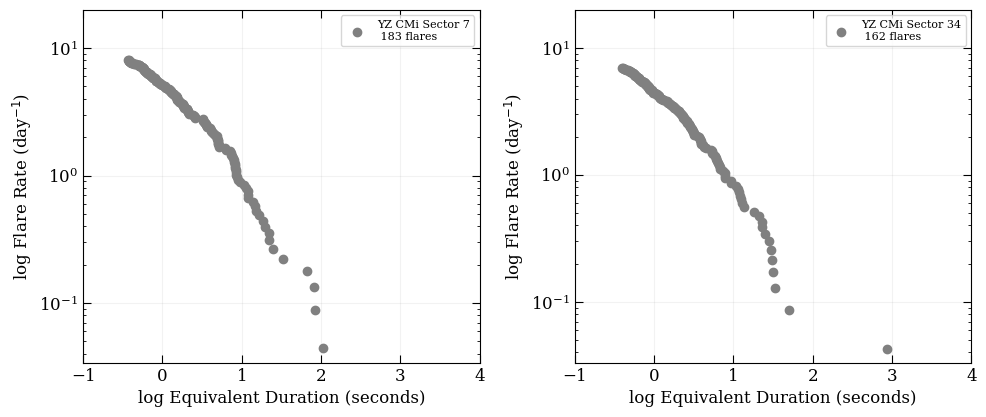

In [22]:
logY=False
do_log = True
fs=12


Lflare = 0

flc_7_ffd = FFD(flc7, TOTEXP=tess_exp_7, 
                Lum=Lflare, fluxerr=flux_err_7, dur=[], 
                logY=logY, est_comp=False,is_altai=True)

flc_34_ffd = FFD(flc34, TOTEXP=tess_exp_34, 
                   Lum=Lflare, fluxerr=flux_err_34, dur=[], 
        logY=logY, est_comp=False,is_altai=True)

flc_7_and_34_ffd = FFD(flc7_and_34, TOTEXP=tess_exp_7_and_34, 
                         Lum=Lflare, fluxerr=flux_err_7_and_34, dur=[], 
        logY=logY, est_comp=False,is_altai=True)



fig=plt.figure(figsize=(10,8))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)

xmin,xmax = -1,4

plot_FFD(fig,ax1,fs=fs,
         ffd_df=flc_7_ffd,
         label='YZ CMi Sector 7\n '+str(len(flc_7_ffd))+' flares',
         color='grey',
         do_log=do_log,
         ymin=None, ymax=20,
         xmin= xmin,xmax = xmax,Lbol=Lflare)

plot_FFD(fig,ax2,fs=fs,
         ffd_df=flc_34_ffd,
         label='YZ CMi Sector 34\n '+str(len(flc_34_ffd))+' flares',
         color='grey',
         do_log=do_log,
         ymin=None, ymax=20,
         xmin= xmin,xmax = xmax,Lbol=Lflare)

fig.tight_layout(pad=1)
plt.show()

# We can also set flare luminosity to our flare luminosity

FFD len check: 183 183 183 183
FFD len check: 162 162 162 162
FFD len check: 345 345 345 345


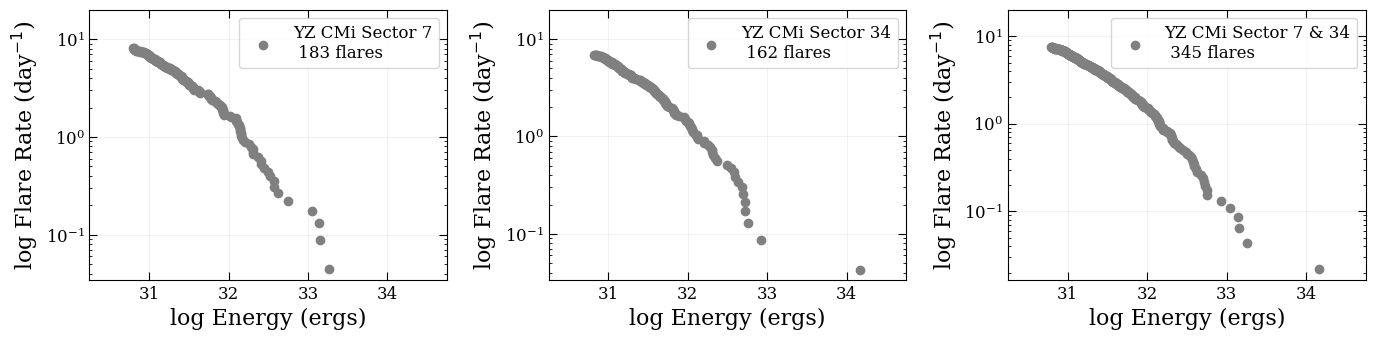

In [23]:
Lflare = np.log10(tess_flare_factor.value)

flc_7_ffd = FFD(flc7, TOTEXP=tess_exp_7, 
                Lum=Lflare, fluxerr=flux_err_7, dur=[], 
                logY=logY, est_comp=False,is_altai=True,)

flc_34_ffd = FFD(flc34, TOTEXP=tess_exp_34, 
                   Lum=Lflare, fluxerr=flux_err_34, dur=[], 
        logY=logY, est_comp=False,is_altai=True)

flc_7_and_34_ffd = FFD(flc7_and_34, TOTEXP=tess_exp_7_and_34, 
                         Lum=Lflare, fluxerr=flux_err_7_and_34, dur=[], 
        logY=logY, est_comp=False,is_altai=True)



fig=plt.figure(figsize=(14,10))
ax1=fig.add_subplot(331)
ax2=fig.add_subplot(332)
ax3=fig.add_subplot(333)

xmin,xmax = 30.25,34.75
fs=16

plot_FFD(fig,ax1,fs=fs,
         ffd_df=flc_7_ffd,
         label='YZ CMi Sector 7\n '+str(len(flc_7_ffd))+' flares',
         color='grey',
         do_log=do_log,
         ymin=None, ymax=20,
         xmin= xmin,xmax = xmax,Lbol=Lflare)

plot_FFD(fig,ax2,fs=fs,
         ffd_df=flc_34_ffd,
         label='YZ CMi Sector 34\n '+str(len(flc_34_ffd))+' flares',
         color='grey',
         do_log=do_log,
         ymin=None, ymax=20,
         xmin= xmin,xmax = xmax,Lbol=Lflare)

plot_FFD(fig,ax3,fs=fs,
         ffd_df=flc_7_and_34_ffd,
         label='YZ CMi Sector 7 & 34\n '+str(len(flc_7_and_34_ffd))+' flares',
         color='grey',
         do_log=do_log,
         ymin=None, ymax=20,
         xmin= xmin,xmax = xmax,Lbol=Lflare)

fig.tight_layout(pad=1)
plt.show()

# what if we wanted to fit a power law to get the slope of these FFD curves?

In [27]:
def linfunc(x, m, b):
    return m * x + b
def linfunc2(E, b, C):
    '''
    From James A.G. Jackman et al. 2022 Eq 2 & 3
    '''    
#     log10nu = np.log(k/b) + b*np.log10(E) #in logspace, inputs should be already logged
    nu = C + b*E 
    return nu

def ffd_slope_fit_and_plot2(ffd_df_orig,ax1,color,label,lw=3,linestyle='--',alpha=0.5,mask=None,logY=False):
    ffd_df = ffd_df_orig.copy(deep=True)
    
    ffd_x = ffd_df['ffd_x'].to_numpy()
    ffd_xerr = ffd_df['ffd_xerr'].to_numpy()
    ffd_y = ffd_df['ffd_y'].to_numpy()
    ffd_yerr = ffd_df['ffd_yerr'].to_numpy()
    
    if logY==True:
        ffd_y = np.log10(ffd_y)
        ffd_yerr = np.log10(ffd_yerr)
        
    
    ffd_x_orig = ffd_x
    ffd_y_orig = ffd_y
    ffd_xerr_orig = ffd_xerr
    ffd_yerr_orig = ffd_yerr
    if mask is not None:
        ffd_x = ffd_x[mask]
        ffd_xerr = ffd_xerr[mask]
        ffd_y = ffd_y[mask]
        ffd_yerr = ffd_yerr[mask]
    
    from scipy.optimize import curve_fit, minimize
    # Fit the FFD w/ a line, save the coefficeints
    if logY==False:
        ffd_ok = np.where((ffd_y > 0) & np.isfinite(ffd_y) &
                          np.isfinite(ffd_x) & np.isfinite(ffd_yerr))[0]
    if logY==True:
        ffd_ok = np.where((10**ffd_y > 0) & np.isfinite(10**ffd_y) &
                          np.isfinite(ffd_x) & np.isfinite(10**ffd_yerr))[0]
    print(len(ffd_x),len(ffd_ok))

    # compute the mean flare energy (bin) for this star

    '''
    # the weights, in log rate units
    ffd_weights = 1. / np.abs(ffd_yerr[ffd_ok]/(ffd_y[ffd_ok] * np.log(10)))
    # fit the FFD w/ a line
    fit, cov = np.polyfit(ffd_x[ffd_ok], np.log10(ffd_y[ffd_ok]), 1, cov=True, w=ffd_weights) # fit using weights
    # evaluate the FFD fit at the Energy point
    fit_E[k] = 10.**(np.polyval(fit, Epoint))
    '''
    if logY==False:
        b_guess = -0.5
        C_guess = np.log10(np.nanmax(ffd_y))        
    else:
        b_guess = -0.5
        C_guess = (np.nanmax(ffd_y))
        
    p0 = [b_guess, C_guess]

    fit, cov = curve_fit(linfunc2, ffd_x[ffd_ok], (ffd_y[ffd_ok]), p0=p0,
                         sigma=np.abs(ffd_yerr[ffd_ok]/(ffd_y[ffd_ok] )) )
    
    fit, cov = curve_fit(linfunc2, ffd_x[ffd_ok], ffd_y[ffd_ok], p0=p0,
                         sigma=np.abs(ffd_yerr[ffd_ok]/(ffd_y[ffd_ok] )) )    
    
    
    b_fit = fit[0]
    C_fit = fit[1]
    a_fit = 1-b_fit
    
    if logY==False:
        ax1.plot(np.linspace(np.min(ffd_x),np.max(ffd_x),len(ffd_x)), 
                 linfunc(np.linspace(np.min(ffd_x),np.max(ffd_x),len(ffd_x)), *fit),\
                 color=color, linewidth=lw,linestyle=linestyle, alpha=alpha,\
#                  label = r'C = '+str(np.round(C_fit,3))+r' ; $\beta$ = '+str(np.round((b_fit),3)) +r' ; $\alpha$ = '+str(np.round((a_fit),3)),
                 label = label+r'$\alpha$ = '+str(np.round((a_fit),3))+r' ; $\beta$ = '+str(np.round((b_fit),3)) +r' ; C = '+str(np.round(C_fit,3)) )
    if logY==True:
        ax1.plot(np.linspace(np.min(ffd_x),np.max(ffd_x),len(ffd_x)), 
                 10**(linfunc(np.linspace(np.min(ffd_x),np.max(ffd_x),len(ffd_x)), *fit)),\
                 color=color, linewidth=lw,linestyle=linestyle, alpha=alpha,\
#                  label = r'C = '+str(np.round(C_fit,3))+r' ; $\beta$ = '+str(np.round((b_fit),3)) +r' ; $\alpha$ = '+str(np.round((a_fit),3)))        
                 label = label+r'$\alpha$ = '+str(np.round((a_fit),3))+r' ; $\beta$ = '+str(np.round((b_fit),3)) +r' ; C = '+str(np.round(C_fit,3)) )
    return fit



def ffd_mask(ffd_df,minE,maxE):
    TESS_ffd_mask = np.where((ffd_df['ffd_x']>=minE) &
                             (ffd_df['ffd_x']<=maxE) )
    return TESS_ffd_mask

def plot_FFD_and_slope(fig,ax,ffd_df,LC,fs,label1,color1,linestyle,do_log,
                       ymin,ymax,xmin,xmax,
                       minE,maxE,
                       Nlim, N3, Lbol, 
                       color2,label2,text_posx=None,do_text=True,eng_lim=None):
    
    
    plot_FFD(fig,ax,fs=fs,
         ffd_df=ffd_df,
         label=label1,
         color=color1,
         do_log=do_log,
         ymin=ymin, ymax=ymax,
         xmin= xmin,xmax = xmax)
    
    
    mask_ffd = ffd_mask(ffd_df,minE=minE, maxE=maxE)
    
    fit_alt = ffd_slope_fit_and_plot2(ffd_df,ax,color=color2,label=label2,linestyle=linestyle,
                                      mask=mask_ffd,logY=do_log,lw=4,alpha=0.85)
    
    
    
    if type(eng_lim)==None:
        eng_lim= calc_min_energy(Nlim=Nlim, N3=N3,
                                 LC=LC, ffd_df =ffd_df, 
                                 Lbol = Lbol)
    

    cad_in_sec = int(np.round(np.nanmedian(np.diff(LC.time))*24*60*60))
    
    if do_text==True:
        ax.axvline(x=minE,linestyle='--',color=color1)
        if type(text_posx)==type(None):
            if type(eng_lim)!=type(None):
                ax.text(x=eng_lim+eng_lim*1/1000,y=ymin+ymin*0.5,
                     s=str(Nlim)+r'$N_{3,\mathrm{'+str(cad_in_sec)+r'}} \times L_{\mathrm{flare}}$'+'\n'+r'$\sim$10^'+str((np.round(eng_lim,2)))+' ergs',
                     transform=ax.transData,fontsize=fs)
        else:
            ax.text(x=text_posx,y=ymin+ymin*0.5,
                 s=str(Nlim)+r'$N_{3,\mathrm{'+str(cad_in_sec)+r'}} \times L_{\mathrm{flare}}$'+'\n'+r'$\sim$10^'+str((np.round(eng_lim,2)))+' ergs',
                 transform=ax.transData,fontsize=fs)
    
def calc_min_energy(Nlim, N3, LC, ffd_df,Lbol):
    cad = np.nanmedian(np.diff(LC.time))
    
    if type(N3)==type(None):
        if cad*24*60*60 < 60: #less than 1 min
            N3=5    
        if (cad*24*60*60 > 60)  & (cad*24*60 <= 30): #b/t 1 min and 30 min
            N3=3
            
    durlim = Nlim * N3
    try:
        durlim_ffd = ffd_df.loc[ffd_df['dur'] >= durlim * cad]
        eng_min = np.log10(np.min(durlim_ffd['equiv_dur'])*(10**Lbol)) # if equiv_dur is in seconds (it should be!)
    except KeyError: # for Ikuta FFDs
        durlim_ffd = ffd_df.loc[ffd_df['dur'] >= durlim * cad]
        eng_min = np.log10(np.min(durlim_ffd['ed_s'])*(10**Lbol))
    
    return eng_min    


107 107
91 91
198 198


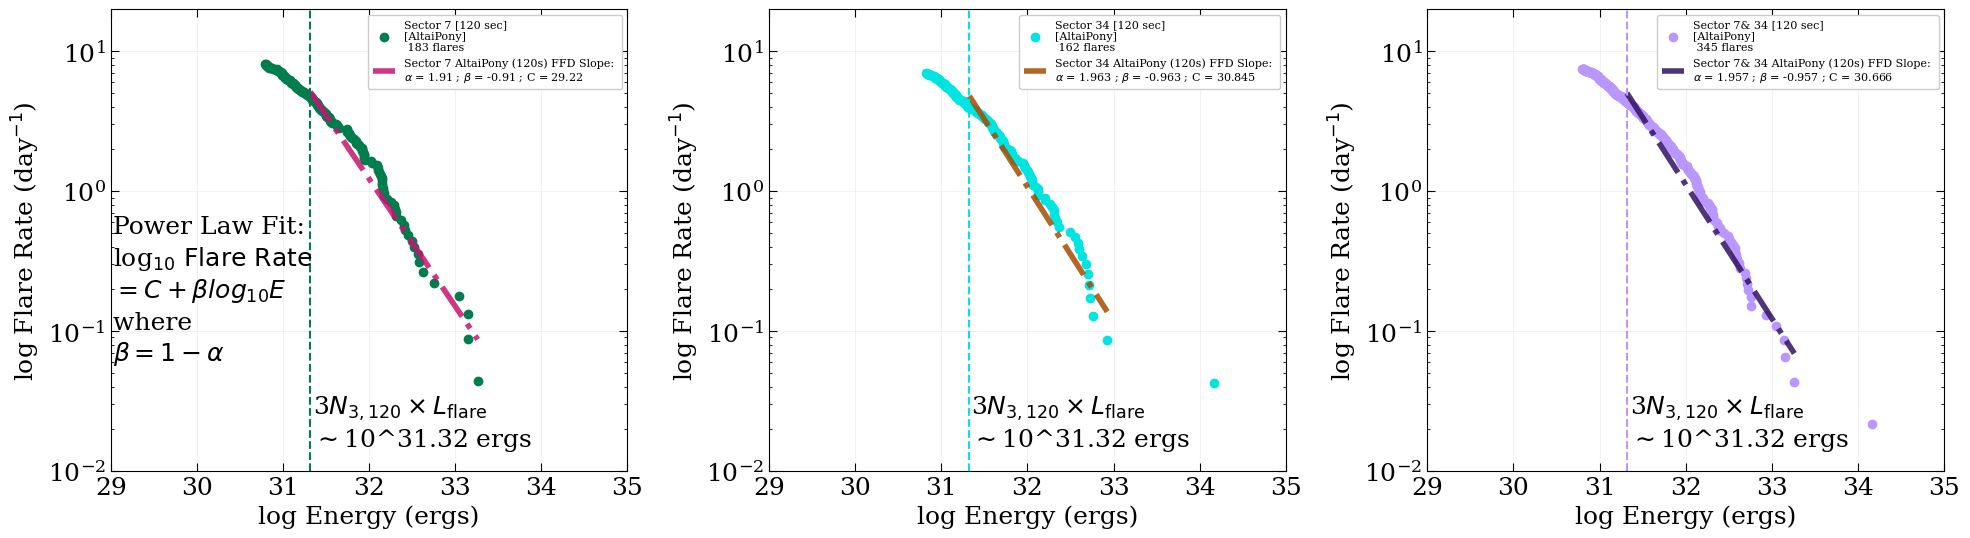

In [37]:
colors=["#007d4d",
"#c91270",
"#00e4e2",
"#a64b00",
"#ba96ff",
"#cade65",
"#2f1360",
"#ff7c8e"]

fig=plt.figure(figsize=(20,16))
ms=1**2
ax1=fig.add_subplot(331)
ax2=fig.add_subplot(332)
ax3=fig.add_subplot(333)

fs=18
Nlim_120=3

ymin,ymax= 1e-2,20
xmin,xmax = 29., 35#.25
Emax=34

altai_eng_lim_120= calc_min_energy(Nlim=Nlim_120, N3=Nlim_120,
                                    LC=TESS_LCDF_smoothed_7, 
                                    ffd_df =flc_7_ffd , Lbol = Lflare)



plot_FFD_and_slope(fig=fig,ax=ax1,ffd_df=flc_7_ffd,
                   LC = TESS_LCDF_smoothed_7,
                   fs=fs,
                   label1='Sector 7 [120 sec]\n[AltaiPony]\n '+str(len(flc_7_ffd))+' flares',
                   color1=colors[0],linestyle='-.',do_log=True,
                   ymin=ymin,ymax=ymax,xmin=xmin,xmax=xmax,
                   minE=altai_eng_lim_120,
                   maxE=Emax,
                   Nlim=Nlim_120, N3=3, Lbol=Lflare,
                   color2=colors[1],
                   label2='Sector 7 AltaiPony (120s) FFD Slope: \n',
                   text_posx=None,do_text=True,
                   eng_lim=altai_eng_lim_120)

plot_FFD_and_slope(fig=fig,ax=ax2,ffd_df=flc_34_ffd,
                   LC = TESS_LCDF_smoothed_34,
                   fs=fs,
                   label1='Sector 34 [120 sec]\n[AltaiPony]\n '+str(len(flc_34_ffd))+' flares',
                   color1=colors[2],linestyle='-.',do_log=True,
                   ymin=ymin,ymax=ymax,xmin=xmin,xmax=xmax,
                   minE=altai_eng_lim_120,
                   maxE=Emax,
                   Nlim=Nlim_120, N3=3, Lbol=Lflare,
                   color2=colors[3],
                   label2='Sector 34 AltaiPony (120s) FFD Slope: \n',
                   text_posx=None,do_text=True,
                   eng_lim=altai_eng_lim_120)

plot_FFD_and_slope(fig=fig,ax=ax3,ffd_df=flc_7_and_34_ffd,
                   LC = TESS_LCDF_smoothed_7_and_34,
                   fs=fs,
                   label1='Sector 7& 34 [120 sec]\n[AltaiPony]\n '+str(len(flc_7_and_34_ffd))+' flares',
                   color1=colors[4],linestyle='-.',do_log=True,
                   ymin=ymin,ymax=ymax,xmin=xmin,xmax=xmax,
                   minE=altai_eng_lim_120,
                   maxE=Emax,
                   Nlim=Nlim_120, N3=3, Lbol=Lflare,
                   color2=colors[6],
                   label2='Sector 7& 34 AltaiPony (120s) FFD Slope: \n',
                   text_posx=None,do_text=True,
                   eng_lim=altai_eng_lim_120)


ax1.legend(loc='upper right',fontsize=8,ncol=1,framealpha=1)#,bbox_to_anchor=(1,1))
ax2.legend(loc='upper right',fontsize=8,ncol=1,framealpha=1)#,bbox_to_anchor=(1,1))
ax3.legend(loc='upper right',fontsize=8,ncol=1,framealpha=1)#,bbox_to_anchor=(1,1))

ax1.text(xmin+0.025,5e-1,'Power Law Fit:')
ax1.text(xmin+0.025,1.75e-1,r'log$_{10}~\mathrm{Flare~Rate}$'+'\n'+r'$= C + \beta log_{10} E$')
ax1.text(xmin+0.025,6.25e-2,'where \n'+r'$\beta = 1 - \alpha$')

fig.tight_layout(pad=1)
plt.show()

In [38]:
print('all done! :D')

all done! :D
